# Result Explorer

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import os
from process import performance, fitness_by_generation

## Settings

In [2]:
sns.set('paper', 'white', font_scale=1.5,
        rc={'xtick.bottom': True,
            'xtick.direction': 'out',
            'ytick.direction': 'out',
            'ytick.left': True})
sns.set_palette(['dimgrey','lightblue','steelblue','lightcoral','maroon'])
pd.options.display.precision = 2
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
os.makedirs('img', exist_ok=True)
fmts = ['png', 'eps']

## Main Experiment

In [4]:
problems = ['02', '04', '14', '27']
problem_names = ['SL', 'CSL', 'CO', 'MD']
seeds = range(1001, 1022)
comparison1 = ['umad', 'rand_bad', 'rand_good', 'rand_mix', 'adapt_mix']
label1 = ['None', 'Rand+Tested-bad', 'Rand+Tested-good', 'Rand+Mixed', 'Adapt+Mixed']
comparison2 = ['adapt_mix']
label2 = ['Adapt+Mixed']

### Read experimental results

In [5]:
with open('dat.main.csv', 'w') as f:
    f.write(
        'problem;method;seed;is_train_solved;is_test_solved;'\
        'train_error;test_error;generation\n'
    )
with open('dat.main.csv', 'a') as f:
    for problem, problem_name in zip(problems, problem_names):
        for method, label in zip(comparison1, label1):
            for seed in seeds:
                try:
                    pvector = performance(f'{problem}/dat/{method}{seed}.log')
                    f.write(
                        '{};{};{};{};{};{};{};{}\n'.format(
                            problem_name,
                            label,
                            seed,
                            *pvector
                        )
                    )
                except FileNotFoundError as e:
                    print(str(e))
dat = pd.read_csv('dat.main.csv', delimiter=';')
dat.head(3)

,problem,method,seed,is_train_solved,is_test_solved,train_error,test_error,generation
0,SL,None,1001,False,False,80.0,375.0,300
1,SL,None,1002,False,False,110.0,565.0,300
2,SL,None,1003,False,False,67.0,324.0,300


In [6]:
for problem in problem_names:
    dat.loc[dat.problem==problem, 'train_error'] = (
        dat[dat.problem==problem].train_error - \
            dat[dat.problem==problem].train_error.min()
    ) / (
        dat[dat.problem==problem].train_error.max() - \
            dat[dat.problem==problem].train_error.min()
    )
    dat.loc[dat.problem==problem, 'test_error'] = (
        dat[dat.problem==problem].test_error - \
            dat[dat.problem==problem].test_error.min()
    ) / (
        dat[dat.problem==problem].test_error.max() - \
            dat[dat.problem==problem].test_error.min()
    )

### Success rate

In [7]:
stat = dat[
    (dat.method=='None') |
    (dat.method=='Rand+Tested-bad') |
    (dat.method=='Rand+Tested-good')
].groupby([
    'problem',
    'method'
]).sum()[[
    'is_test_solved'
]]
stat

is_test_solved
problem method                          
CO      None                           0
        Rand+Tested-bad                0
        Rand+Tested-good              15
CSL     None                           1
        Rand+Tested-bad                0
        Rand+Tested-good              15
MD      None                           5
        Rand+Tested-bad                0
        Rand+Tested-good              15
SL      None                           1
        Rand+Tested-bad                0
        Rand+Tested-good              19

In [8]:
for problem_name in problem_names:
    v1, v2 = sorted(stat.is_test_solved[problem_name].values, reverse=True)[:2]
    print(problem_name, v1, v2, fisher_exact([[v1, v2], [21-v1,21-v2]]))

SL 19 1 (190.0, 1.7248238141725344e-08)
CSL 15 1 (50.0, 1.3931835196655148e-05)
CO 15 0 (inf, 1.0998817260517281e-06)
MD 15 5 (8.0, 0.004804479731375075)


In [9]:
stat = dat[
    (dat.method=='None') |
    (dat.method=='Rand+Mixed') |
    (dat.method=='Adapt+Mixed')
].groupby([
    'problem',
    'method'
]).sum()[[
    'is_test_solved'
]]
stat

is_test_solved
problem method                     
CO      Adapt+Mixed              14
        None                      0
        Rand+Mixed               12
CSL     Adapt+Mixed              14
        None                      1
        Rand+Mixed               11
MD      Adapt+Mixed              20
        None                      5
        Rand+Mixed               17
SL      Adapt+Mixed              17
        None                      1
        Rand+Mixed               15

In [10]:
for problem_name in problem_names:
    v1, v2 = sorted(stat.is_test_solved[problem_name].values, reverse=True)[:2]
    print(problem_name, v1, v2, fisher_exact([[v1, v2], [21-v1,21-v2]]))

SL 17 15 (1.7, 0.7185879381001337)
CSL 14 11 (1.8181818181818181, 0.5302649566194443)
CO 14 12 (1.5, 0.7513167417397034)
MD 20 17 (4.705882352941177, 0.3433395872420253)


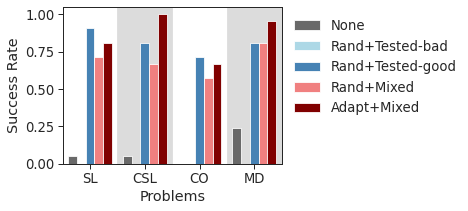

In [11]:
plt.figure(figsize=(6.4, 3.2))
ax = sns.barplot(
    x='problem',
    y='is_train_solved',
    data=dat,
    hue='method',
    errwidth=0,
    saturation=1,
)
rect1 = matplotlib.patches.Rectangle(( 0.5,0), 1, 1.05, color='gainsboro', zorder=0)
rect2 = matplotlib.patches.Rectangle(( 2.5,0), 1, 1.05, color='gainsboro', zorder=0)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.set_xlabel('Problems')
ax.set_ylabel('Success Rate')
ax.legend(
    bbox_to_anchor=(1., 1.),
    loc='upper left',
    facecolor='none',
    framealpha=0.
)
plt.subplots_adjust(right=0.6, bottom=0.2)
for fmt in fmts:
    plt.savefig(f'img/main.success.rate.train.{fmt}', dpi=600)

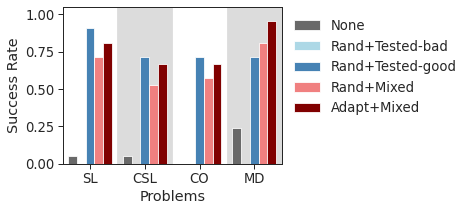

In [12]:
plt.figure(figsize=(6.4, 3.2))
ax = sns.barplot(
    x='problem',
    y='is_test_solved',
    data=dat,
    hue='method',
    errwidth=0,
    saturation=1
)
rect1 = matplotlib.patches.Rectangle(( 0.5,0), 1, 1.05, color='gainsboro', zorder=0)
rect2 = matplotlib.patches.Rectangle(( 2.5,0), 1, 1.05, color='gainsboro', zorder=0)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.set_xlabel('Problems')
ax.set_ylabel('Success Rate')
ax.legend(
    bbox_to_anchor=(1., 1.),
    loc='upper left',
    facecolor='none',
    framealpha=0.
)
plt.subplots_adjust(right=0.6, bottom=0.2)
for fmt in fmts:
    plt.savefig(f'img/main.success.rate.test.{fmt}', dpi=600)

### Error

In [13]:
dat.groupby([
    'problem',
    'method'
]).aggregate([
    np.min,
    np.median,
    np.max,
    np.mean,
    np.std
])[[
    'train_error',
    'test_error'
]]

train_error                              test_error  \
                                amin median  amax      mean   std       amin   
problem method                                                                 
CO      Adapt+Mixed             0.00   0.00  0.90  2.08e-01  0.34   0.00e+00   
        None                    0.74   0.88  0.98  8.88e-01  0.06   6.29e-04   
        Rand+Mixed              0.00   0.00  0.99  3.03e-01  0.41   0.00e+00   
        Rand+Tested-bad         0.81   0.89  1.00  8.97e-01  0.05   7.84e-04   
        Rand+Tested-good        0.00   0.00  0.80  1.85e-01  0.34   0.00e+00   
CSL     Adapt+Mixed             0.00   0.00  0.00  0.00e+00  0.00   0.00e+00   
        None                    0.00   0.45  0.82  4.24e-01  0.21   0.00e+00   
        Rand+Mixed              0.00   0.00  0.27  5.41e-02  0.09   0.00e+00   
        Rand+Tested-bad         0.45   0.59  1.00  6.28e-01  0.14   1.22e-05   
        Rand+Tested-good        0.00   0.00  0.36  3.46e-02  0.09   0.00e+00   
MD      Adapt+Mixed             0.00   0.00  0.10  4.91e-03  0.02   0.00e+00   
        None                    0.00   0.08  0.35  8.15e-02  0.08   0.00e+00   
        Rand+Mixed              0.00   0.00  0.30  3.29e-02  0.08   0.00e+00   
        Rand+Tested-bad         0.08   0.63  1.00  5.95e-01  0.26   1.56e-01   
        Rand+Tested-good        0.00   0.00  0.06  9.33e-03  0.02   0.00e+00   
SL      Adapt+Mixed             0.00   0.00  1.00  1.08e-01  0.26   0.00e+00   
        None                    0.00   0.31  0.55  3.16e-01  0.15   0.00e+00   
        Rand+Mixed              0.00   0.00  0.37  7.06e-02  0.12   0.00e+00   
        Rand+Tested-bad         0.14   0.54  1.00  6.25e-01  0.21   8.91e-02   
        Rand+Tested-good        0.00   0.00  0.25  1.93e-02  0.06   0.00e+00   

                                                                  
                            median      amax      mean       std  
problem method                                                    
CO      Adapt+Mixed       0.00e+00  9.47e-04  1.93e-04  3.21e-04  
        None              8.65e-04  9.83e-04  8.69e-04  8.25e-05  
        Rand+Mixed        0.00e+00  1.15e-03  2.95e-04  4.09e-04  
        Rand+Tested-bad   8.43e-04  9.91e-04  8.56e-04  6.05e-05  
        Rand+Tested-good  0.00e+00  1.00e+00  4.77e-02  2.18e-01  
CSL     Adapt+Mixed       0.00e+00  1.67e-01  7.94e-03  3.64e-02  
        None              1.79e-05  9.17e-01  7.94e-02  2.41e-01  
        Rand+Mixed        0.00e+00  1.00e+00  4.76e-02  2.18e-01  
        Rand+Tested-bad   2.22e-05  1.67e-01  7.96e-03  3.64e-02  
        Rand+Tested-good  0.00e+00  1.14e-05  1.66e-06  3.55e-06  
MD      Adapt+Mixed       0.00e+00  1.29e-01  6.15e-03  2.82e-02  
        None              1.37e-01  4.54e-01  1.29e-01  1.02e-01  
        Rand+Mixed        0.00e+00  1.76e-01  2.72e-02  5.86e-02  
        Rand+Tested-bad   6.31e-01  1.00e+00  6.08e-01  2.70e-01  
        Rand+Tested-good  0.00e+00  2.00e-01  2.60e-02  5.71e-02  
SL      Adapt+Mixed       0.00e+00  1.00e+00  9.24e-02  2.62e-01  
        None              1.12e-01  3.55e-01  1.47e-01  9.84e-02  
        Rand+Mixed        0.00e+00  1.09e-01  2.83e-02  4.59e-02  
        Rand+Tested-bad   2.20e-01  8.97e-01  4.30e-01  2.79e-01  
        Rand+Tested-good  0.00e+00  1.35e-01  9.84e-03  3.27e-02

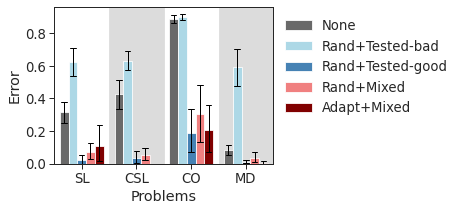

In [14]:
plt.figure(figsize=(6.4, 3.2))
ax = sns.barplot(
    x='problem',
    y='train_error',
    data=dat,
    hue='method',
    errcolor='black',
    errwidth=1,
    capsize=0.1,
    saturation=1
)
rect1 = matplotlib.patches.Rectangle(( 0.5,0), 1, 1.05, color='gainsboro', zorder=0)
rect2 = matplotlib.patches.Rectangle(( 2.5,0), 1, 1.05, color='gainsboro', zorder=0)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.set_xlabel('Problems')
ax.set_ylabel('Error')
ax.legend(
    bbox_to_anchor=(1., 1.),
    loc='upper left',
    facecolor='none',
    framealpha=0.
)
plt.subplots_adjust(right=0.6, bottom=0.2)
for fmt in fmts:
    plt.savefig(f'img/main.error.train.{fmt}', dpi=600)

### Generation (successful runs)

In [15]:
dat.groupby([
    'problem',
    'method'
]).aggregate([
    np.min,
    np.median,
    np.max,
    np.mean,
    np.std
])['generation']

amin  median  amax    mean     std
problem method                                              
CO      Adapt+Mixed         33   135.0   300  181.57  103.56
        None               300   300.0   300  300.00    0.00
        Rand+Mixed          30   275.0   300  224.76   96.46
        Rand+Tested-bad    300   300.0   300  300.00    0.00
        Rand+Tested-good    21   193.0   300  176.38   98.31
CSL     Adapt+Mixed         32   100.0   252  106.90   57.11
        None               194   300.0   300  294.95   23.13
        Rand+Mixed          49   167.0   300  189.29   95.88
        Rand+Tested-bad    300   300.0   300  300.00    0.00
        Rand+Tested-good    43   121.0   300  156.05   90.96
MD      Adapt+Mixed         14    32.0   300   61.24   65.10
        None                61   300.0   300  270.14   72.64
        Rand+Mixed           8   115.0   300  155.33  106.78
        Rand+Tested-bad    300   300.0   300  300.00    0.00
        Rand+Tested-good     9    86.0   300  123.10  108.80
SL      Adapt+Mixed         12    41.0   300   98.86  112.08
        None               118   300.0   300  291.33   39.72
        Rand+Mixed          14   113.0   300  155.71  112.25
        Rand+Tested-bad    300   300.0   300  300.00    0.00
        Rand+Tested-good    11    33.0   300   62.95   83.79

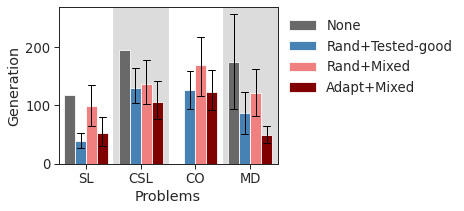

In [16]:
plt.figure(figsize=(6.4, 3.2))
ax = sns.barplot(
    x='problem',
    y='generation',
    data=dat[dat['is_test_solved']],
    hue='method',
    errcolor='black',
    errwidth=1,
    capsize=0.125,
    palette=sns.color_palette(['dimgrey','steelblue','lightcoral','maroon']),
    saturation=1
)
rect1 = matplotlib.patches.Rectangle(( 0.5,0), 1, 300, color='gainsboro', zorder=0)
rect2 = matplotlib.patches.Rectangle(( 2.5,0), 1, 300, color='gainsboro', zorder=0)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.set_xlabel('Problems')
ax.set_ylabel('Generation')
ax.legend(
    bbox_to_anchor=(1., 1.),
    loc='upper left',
    facecolor='none',
    framealpha=0.
)
plt.subplots_adjust(right=0.6, bottom=0.2)
for fmt in fmts:
    plt.savefig(f'img/main.generation.{fmt}', dpi=600)

### Evolutionary Process

In [17]:
with open('dat.main.fit.csv', 'w') as f:
    f.write(
        'problem;method;seed;generation;fitness\n'
    )
with open('dat.main.fit.csv', 'a') as f:
    for problem, problem_name in zip(problems, problem_names):
        for method, label in zip(comparison1, label1):
            for seed in seeds:
                try:
                    fitnesses = fitness_by_generation(
                        f'{problem}/dat/{method}{seed}.log',
                        300
                    )
                    for i, fit in enumerate(fitnesses):
                        f.write(
                            '{};{};{};{};{}\n'.format(
                                problem_name,
                                label,
                                seed,
                                i+1,
                                fit
                            )
                        )
                except FileNotFoundError as e:
                    print(str(e))
dat = pd.read_csv('dat.main.fit.csv', delimiter=';')
dat.head(3)

,problem,method,seed,generation,fitness
0,SL,None,1001,1,418.0
1,SL,None,1001,2,368.0
2,SL,None,1001,3,312.0


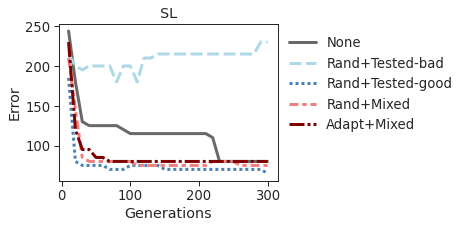

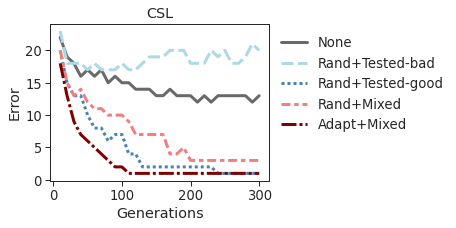

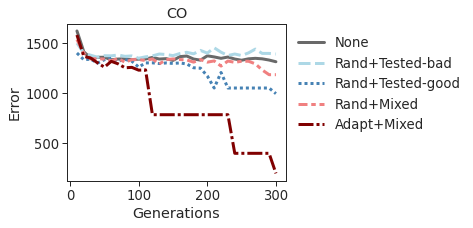

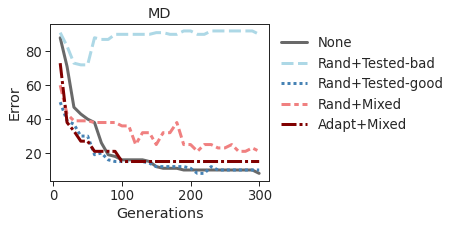

In [18]:
for problem_name in problem_names:
    plt.figure(figsize=(6.4, 3.2))
    ax = sns.lineplot(
        x='generation',
        y='fitness',
        data=dat[(dat.problem==problem_name) & (dat.generation%10==0)],
        hue='method',
        style='method',
        estimator=np.median,
        err_style=None,
        linewidth=3,
    )
    ax.set_title(f'{problem_name}')
    ax.set_xlabel('Generations')
    ax.set_ylabel('Error')
    leg = ax.legend(
        bbox_to_anchor=(1., 1.),
        loc='upper left',
        facecolor='none',
        framealpha=0.
    )
    for line in leg.get_lines():
        line.set_linewidth(3)
    plt.subplots_adjust(right=0.6, bottom=0.2)
    for fmt in fmts:
        plt.savefig(f'img/main.fitness.{problem_name}.{fmt}', dpi=600)
    plt.show()